In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
img_size = 224  # MobileNet expects 224x224 pixel images
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    r'C:\Users\TAHMID HOSSAIN\Desktop\data\train',  # Replace with your dataset path
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    r'C:\Users\TAHMID HOSSAIN\Desktop\data\val',  # Replace with your dataset path
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 4571 images belonging to 4 classes.
Found 262 images belonging to 4 classes.


In [3]:
def create_mobilenet_model():
    base_model = MobileNet(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model for transfer learning

    # Add a global average pooling layer and a dense layer for classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)  # Optional layer for added complexity
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)

    # Combine base and custom layers into a complete model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

model = create_mobilenet_model()


In [4]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [5]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10  # Adjust based on your dataset size and resources
)

loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')


base_model = model.layers[0]  # Access the base model layer
base_model.trainable = True

# Compile with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune for additional epochs
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=20  # Fine-tune for a few more epochs
)



Epoch 1/10


C:\Users\TAHMID HOSSAIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


142/142 ━━━━━━━━━━━━━━━━━━━━ 113s 773ms/step - accuracy: 0.7656 - loss: 0.8215 - val_accuracy: 0.8320 - val_loss: 0.4502
Epoch 2/10
  1/142 ━━━━━━━━━━━━━━━━━━━━ 1:40 713ms/step - accuracy: 1.0000 - loss: 0.0757

C:\Users\TAHMID HOSSAIN\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0757 - val_accuracy: 0.6667 - val_loss: 1.4404
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 110s 768ms/step - accuracy: 0.9320 - loss: 0.1841 - val_accuracy: 0.8438 - val_loss: 0.3720
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 0.0472 - val_accuracy: 0.8333 - val_loss: 0.4762
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 109s 767ms/step - accuracy: 0.9615 - loss: 0.1138 - val_accuracy: 0.8906 - val_loss: 0.3222
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9375 - loss: 0.1165 - val_accuracy: 1.0000 - val_loss: 0.0210
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 109s 764ms/step - accuracy: 0.9716 - loss: 0.0729 - val_accuracy: 0.8867 - val_loss: 0.3245
Epoch 8/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 0.0291 - val_accuracy: 0.8333 - val_loss: 0.7009
Epoch 9/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 110s 767ms/step - accuracy: 0.9776 - loss: 0.0641 - val_accurac

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 746ms/step


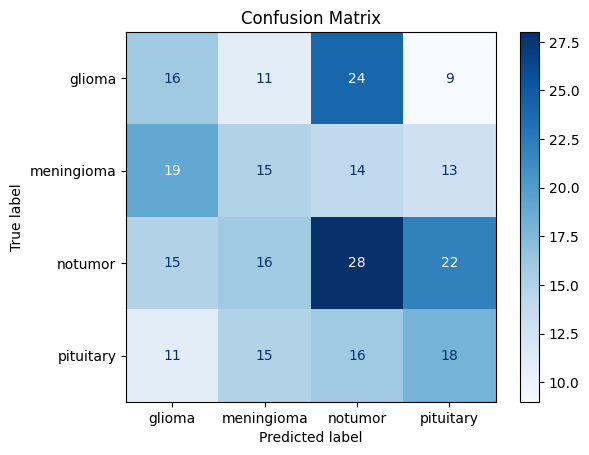

In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get the true labels and predictions
val_labels = validation_generator.classes
val_predictions = model.predict(validation_generator)
val_pred_classes = np.argmax(val_predictions, axis=1)

# Calculate and plot confusion matrix
cm = confusion_matrix(val_labels, val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
